In [1]:
import os
import pickle
from tqdm import tqdm, trange
import os
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
sns.set_style("darkgrid")
import matplotlib.cm as cm

## Now visualize the empirical game matrix

In [62]:
# f = open('cross_play_evals/results_cross_play_20K_episodes_binding_for_payoff_matrix_1_2021_03_23_12_37_37.pickle', "rb")
# f = open('cross_play_evals/results_cross_play_20K_episodes_binding_prosocial_2021_05_15_09_10_05.pickle', "rb")
f = open('cross_play_evals/results_more_games_cross_play_20K_episodes_binding_prosocial_2021_05_20_01_53_31.pickle', 'rb')

In [63]:
binary_data = f.read() # 10 mins max

In [64]:
results = pickle.loads(binary_data) # 1 min

In [65]:
res_dict = defaultdict(list)
for res in tqdm(results):
    res_dict[(res[0], res[1])].append(res[3])

100%|██████████| 3600/3600 [00:00<00:00, 703348.91it/s]


In [6]:
k = list(res_dict.keys())

In [7]:
k

[(('custom_vs_custom_1', 'custom_vs_custom_2'), 0),
 (('default_vs_default', 'default_vs_default'), 0),
 (('custom_vs_custom_1', 'default_vs_default'), 0),
 (('default_vs_default', 'custom_vs_custom_1'), 0),
 (('default_vs_custom', 'custom_vs_custom_1'), 0),
 (('custom_vs_custom_1', 'default_vs_custom'), 0)]

In [8]:
len(res_dict[k[0]])

2500

In [9]:
res_dict[k[0]][0]

{'player0_raw': array([ 6., 14.,  0., ..., 10., 11., 16.], dtype=float32),
 'player1_raw': array([ 8.,  5.,  0., ...,  4.,  2., 15.], dtype=float32),
 'sum_raw': array([14., 19.,  0., ..., 14., 13., 31.], dtype=float32),
 'player0_share_of_max': array([1.       , 0.875    , 0.       , ..., 0.6666667, 0.9166667,
        0.8      ], dtype=float32),
 'player1_share_of_max': array([0.22857143, 0.2       , 0.        , ..., 0.33333334, 0.18181819,
        1.        ], dtype=float32),
 'sum_share_of_max': array([0.4       , 0.61290324, 0.        , ..., 0.7777778 , 0.8666667 ,
        0.8857143 ], dtype=float32),
 'difference_in_share_of_max': array([0.7714286 , 0.675     , 0.        , ..., 0.33333334, 0.7348485 ,
        0.19999999], dtype=float32),
 'num_turns': array([6, 4, 4, ..., 4, 4, 4])}

In [66]:
import datetime
from ray import tune
import os
import torch
import pickle
from tqdm import tqdm, trange
from tqdm.contrib.concurrent import process_map
import numpy as np
from collections import defaultdict
import multiprocessing

from marltoolbox.algos.alternating_offers.alt_offers_training import AltOffersTraining, run_episode
from marltoolbox.algos.alternating_offers.envs.alt_offers_env import AltOffersEnv
from marltoolbox.experiments.tune_class_api.alternating_offers.cond_params import cond_params_iter, cond_params_iter_pop_training, default_cond_params, round_cond_params


# eval_episodes = 128
# checkpoint_dir_name = 'checkpoint_312'  # for 20K episodes

# cond_params - changing agent parameters and not trial parameters here
cond_params_list = list(cond_params_iter())

# root_path = '/home/alex_grig_lyzhov/ray_results/cross_play_20K_episodes/2021_03_18/22_47_17'
# binding = False

# root_path = '/home/alex_grig_lyzhov/ray_results/cross_play_20K_episodes_binding/2021_03_20/20_17_24'
# binding = True

# root_path = '/home/alexander/ray_results/cross_play_20K_episodes_cheap/2021_03_24/05_30_06'
# binding = False

# root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding/2021_03_23/12_37_37'
# binding = True

root_path = '/home/alexander/ray_results/cross_play_20K_episodes_binding_prosocial/2021_05_15/09_10_05'  # IMPORTANT!!!!!!!
binding = True


eval_episodes = 64
# checkpoint_dir_name = 'checkpoint_1'
checkpoint_dir_name = 'checkpoint_312'  # for 20K episodes
# binding = True
# default_cond_params = default_cond_params

# root_path = '/home/alexander/ray_results/population_experiments/2021_04_20/14_01_26'
# cond_params_list = list(cond_params_iter_pop_training())

# root_path = '/home/alexander/ray_results/cross_play_20K_episodes_best_response_fixed_agent_0/2021_05_03/00_35_50'
# root_path = '/home/alexander/ray_results/cross_play_20K_episodes_best_response_fixed_agent_1/2021_05_03/09_05_24'
# cond_params_list = list(cond_params_iter())

In [67]:
default_indices = []
trial_info = []
for i, trial_name in enumerate(os.listdir(root_path)):
    trial_path = os.path.join(root_path, trial_name)
#     print(trial_path)
    if os.path.isdir(trial_path):
        cur_trial_info = {}
        cur_trial_info['params'] = pickle.load(open(os.path.join(trial_path, 'params.pkl'), 'rb'))
        model_path = os.path.join(trial_path, checkpoint_dir_name, 'model.pth')
        with open(model_path, 'rb') as f:
            state = torch.load(f)
        cur_trial_info['agents'] = []
        for agent_i in range(2):
            cur_trial_info['agents'].append(state['agent%s' % agent_i]['model_state'])  # either a single model or a list of population models
        trial_info.append(cur_trial_info)
        # disable for population training
        if cur_trial_info['params']['cond_params'] == default_cond_params:  # if custom params == default params
            default_indices.append(len(trial_info)-1)  # correspond to default_vs_default plays

In [68]:
len(matches['custom_vs_custom_1'])

130

In [39]:
# [m['params']['cond_params'] for m in matches['custom_vs_custom_1']]

In [69]:
matches = {}
# matches['custom_vs_custom_1'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_custom_1')]
# matches['custom_vs_custom_2'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_custom_2')]
# matches['default_vs_custom'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'default_vs_custom')]
# matches['custom_vs_default'] = [trial for trial in trial_info if (trial['params']['match_mode'] == 'custom_vs_default')]
# disable for population training
matches['default_vs_default'] = [trial_info[default_i] for default_i in default_indices]
all_training_modes = list(set([trial['params']['match_mode'] for trial in trial_info]))

for mode in all_training_modes:
    matches[mode] = [trial for trial in trial_info if trial['params']['match_mode'] == mode]

# now sort training matches for various regimes in the order prescribed by cond_params_list
match_indices = defaultdict(list)
for match_regime, match_trials in matches.items():
# disable for population training
    if match_regime == 'default_vs_default':
        match_indices['default_vs_default'] = [list(range(len(matches['default_vs_default'])))
                                               for cond_params_i in range(len(cond_params_list))]
    else:
        for cond_params_i, cond_params in enumerate(cond_params_list):
#             eq_list = [(i, trial) for (i, trial) in enumerate(match_trials) if round_cond_params(trial['params']['cond_params']) == cond_params]
#             print(cond_params)
            eq_list = [(i, trial) for (i, trial) in enumerate(match_trials) if round_cond_params(trial['params']['cond_params']) == round_cond_params(cond_params)]
#             print(cond_params)
#             print(len(eq_list))
            indices = [eq_trial[0] for eq_trial in eq_list]
            match_indices[match_regime].append(indices)

In [70]:
# matrices_list = []
cond_params_i_list = [0,] + list(range(7, 14))  # must be synced to corresponding loop in eval
matrix = np.zeros((len(cond_params_i_list)*5, len(cond_params_i_list)*5, 2))
for run_i in range(5):
    for run_j in range(5):
    # args_list = []
#     for agent_0_match_regime, agent_1_match_regime in (
#            ('custom_vs_custom_1', 'custom_vs_custom_2'),  # include custom_vs_custom_2 agent 1 which isn't playing with others really.
#     #        ('default_vs_default', 'default_vs_default'),  # kinda mirrors custom_vs_custom_1, default_vs_default with 0?

#     #        ('custom_vs_custom_1', 'default_vs_default'),  # 2.1
#     #        ('default_vs_default', 'custom_vs_custom_1'),  # 2.2

#     #        ('default_vs_custom', 'custom_vs_custom_1'),  # 3.1  # includes default_vs_custom, don't have all the cells for it
#     #                                                    ('custom_vs_custom_1', 'default_vs_custom'),  # 4.1  # this was disrupted by stop of computation!
#     ):
        agent_0_match_regime = 'custom_vs_custom_1'
        agent_1_match_regime = 'custom_vs_custom_2'
        len_sum = 0
    #     cond_params_i_list = list(range(7, 14))
        
        mat0 = np.zeros((len(cond_params_i_list), len(cond_params_i_list)))
        mat1 = np.zeros((len(cond_params_i_list), len(cond_params_i_list)))
    #     for ind_0, cond_params_i_0 in enumerate([0,] + list(range(7, 14))):  # over all types of agents
        for ind_0, cond_params_i_0 in enumerate(cond_params_i_list):  # over all types of agents
            for ind_1, cond_params_i_1 in enumerate(cond_params_i_list):  # over all types of agents
    #             trial_0_indices = match_indices[agent_0_match_regime][cond_params_i_0][2:3]
    #             trial_1_indices = match_indices[agent_1_match_regime][cond_params_i_1][2:3]
                trial_0_indices = match_indices[agent_0_match_regime][cond_params_i_0]
                trial_1_indices = match_indices[agent_1_match_regime][cond_params_i_1]
#                 print(trial_0_indices)
#                 print(trial_1_indices)
                eval_trials_list = [(trial_0_i, trial_1_i) for trial_0_i in trial_0_indices for trial_1_i in trial_1_indices]
                len_sum += len(eval_trials_list)
    #             print(trial_0_indices)
    #             print(trial_1_indices)
    #             if agent_0_match_regime == agent_1_match_regime:  # removing this clause completely!
    #                 eval_trials_list = [(trial_0_i, trial_0_i) for trial_0_i in trial_0_indices]  # to match agents trained together
    #             else:
    #             print(agent_0_match_regime, agent_1_match_regime, cond_params_i_0, cond_params_i_1, len_sum, len(cur_res_dict))
                
#                 r0 = np.concatenate([inner['player0_share_of_max'] for inner in cur_res_dict[len_sum-len(eval_trials_list):len_sum]]).mean()
#                 r1 = np.concatenate([inner['player1_share_of_max'] for inner in cur_res_dict[len_sum-len(eval_trials_list):len_sum]]).mean()
                
    #             print(len(cur_res_dict))
    #             print(len_sum)
    #             print(len(eval_trials_list))
    #             print(len(cur_res_dict[len_sum-len(eval_trials_list):len_sum]))
    #             print(agent_0_match_regime, agent_1_match_regime, cond_params_i_0, cond_params_i_1, r0, r1)

                cur_res_dict = res_dict[(agent_0_match_regime, agent_1_match_regime), 0]
#                 print(eval_trials_list)
#                 print(run_i, run_j)
#                 print((trial_0_indices[run_i], trial_1_indices[run_j]))
                eval_trials_ind = eval_trials_list.index((trial_0_indices[run_i], trial_1_indices[run_j]))
#                 r0 = cur_res_dict[len_sum - len(eval_trials_list) + eval_trials_ind]['player0_share_of_max'].mean()
#                 r1 = cur_res_dict[len_sum - len(eval_trials_list) + eval_trials_ind]['player1_share_of_max'].mean()
                r0 = cur_res_dict[len_sum - len(eval_trials_list) + eval_trials_ind][0]
                r1 = cur_res_dict[len_sum - len(eval_trials_list) + eval_trials_ind][2]

                matrix[run_i*len(cond_params_i_list)+ind_0, run_j*len(cond_params_i_list)+ind_1, 0] = r0
                matrix[run_i*len(cond_params_i_list)+ind_0, run_j*len(cond_params_i_list)+ind_1, 1] = r1
#                 mat0[ind_0, ind_1] = r0
#                 mat1[ind_0, ind_1] = r1

#         mat0 = mat0[1:8, 1:8]
#         mat1 = mat1[1:8, 1:8]
#         matrices_list.append(np.dstack((mat0, mat1)))
        
#             for trial_0_i, trial_1_i in eval_trials_list:
#                 trial_0 = matches[agent_0_match_regime][trial_0_i]
#                 trial_1 = matches[agent_1_match_regime][trial_1_i]

#                 if 'default' in agent_0_match_regime.split('_vs_')[0]:
#                     agent_0_params = default_cond_params
#                 else:
#                     agent_0_params = trial_0['params']['cond_params']
#                 if 'default' in agent_1_match_regime.split('_vs_')[1]:
#                     agent_1_params = default_cond_params
#                 else:
#                     agent_1_params = trial_1['params']['cond_params']

#                 else:
#                     args_list.append(((agent_0_match_regime, agent_1_match_regime), 0,
#                                       (trial_0_i, trial_1_i), (agent_0_params, agent_1_params),))

In [71]:
matrix = np.delete(matrix, [8*i for i in range(5)], axis=0)
matrix = np.delete(matrix, [8*i for i in range(5)], axis=1)

In [72]:
matrix.shape

(35, 35, 2)

In [55]:
# pickle.dump(matrix, open('empirical_game_matrices_prosociality_coeff_0.3', 'wb'))
pickle.dump(matrix, open('empirical_game_matrices_prosociality_coeff_1.0', 'wb'))

In [99]:
matrix.shape

(35, 35, 2)

In [2]:
m = pickle.load(open('empirical_game_matrices_prosociality_coeff_0.3', 'rb'))

In [3]:
m.shape

(35, 35, 2)

In [4]:
np.diagonal(m[1:7, 8:14, :]).mean()

0.46033714711666107

In [108]:
m[1:7, 8:14, :][np.where(~np.eye(6, dtype=bool))].mean()

0.45179340889056524

In [5]:
m[1:7, 8:14, :].shape

(6, 6, 2)

<AxesSubplot:>

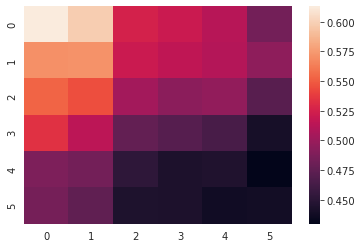

In [8]:
sns.heatmap(m[1:7, 8:14, 0])

<AxesSubplot:>

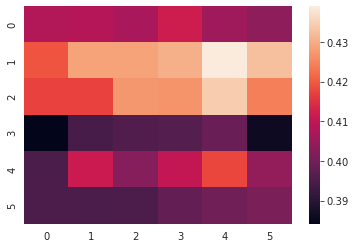

In [7]:
sns.heatmap(m[1:7, 8:14, 1])

<AxesSubplot:>

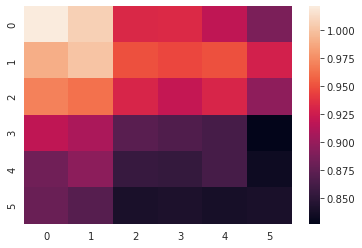

In [9]:
sns.heatmap(m[1:7, 8:14, :].sum(axis=2))

### Syncing to my plot values

In [40]:
print(x[1:7], y[1:7])  # default vs custom, starts from 1

(0.651958, 0.57897437, 0.5209278, 0.4904595, 0.44816065, 0.3652433) (0.2946116, 0.30257654, 0.31327945, 0.29468426, 0.29970247, 0.25992543)


In [48]:
# [mat0[0, i] for i in range(1, mat0.shape[0])], [mat1[0, i] for i in range(1, mat1.shape[0])]  # NO, doesn't match at all!

In [78]:
np.array([mat0[0, i] for i in range(1, mat0.shape[0])]) - np.array((0.651958, 0.57897437, 0.5209278, 0.4904595, 0.44816065, 0.3652433))

array([-0.02253021, -0.00537897, -0.08513601, -0.03813672, -0.09787542,
        0.00109933])

In [59]:
np.array([mat1[0, i] for i in range(1, mat1.shape[0])]) - np.array((0.2946116, 0.30257654, 0.31327945, 0.29468426, 0.29970247, 0.25992543))

array([ 0.00567922,  0.00254023, -0.0408254 , -0.00701216, -0.046008  ,
       -0.00201893])

In [79]:
for i in range(5):
    mat0 = matrix[7*i:7*(i+1), 7*i:7*(i+1), 0]
    mat1 = matrix[7*i:7*(i+1), 7*i:7*(i+1), 1]
    print(np.array([mat0[0, i] for i in range(1, mat0.shape[0])]) - np.array((0.651958, 0.57897437, 0.5209278, 0.4904595, 0.44816065, 0.3652433)))

[-0.02253021 -0.00537897 -0.08513601 -0.03813672 -0.09787542  0.00109933]
[ 0.00168698  0.02435433 -0.04531731 -0.02991992 -0.00760847  0.0362622 ]
[ 0.02784054  0.01059335 -0.02986617  0.01934809 -0.08744234  0.00439294]
[ 0.04456924 -0.04036415 -0.11257233 -0.11758724 -0.10392285 -0.01071002]
[-0.00070424 -0.06753338 -0.00384117  0.00927052  0.01028573  0.05523045]


In [41]:
print(x[7:14], y[7:14])  # custom vs custom, starts from 0

(0.7376215, 0.6129167, 0.54170287, 0.4994951, 0.46781248, 0.4270572, 0.42730743) (0.30001095, 0.39960298, 0.41811663, 0.42247146, 0.40760374, 0.40898776, 0.3982173)


In [54]:
np.array([mat0[i, i] for i in range(mat0.shape[0])]) - np.array((0.7376215, 0.6129167, 0.54170287, 0.4994951, 0.46781248, 0.4270572, 0.42730743))

array([-0.00565852,  0.006948  ,  0.0041576 , -0.00838591,  0.00975188,
        0.00553927, -0.00058437])

In [55]:
np.array([mat1[i, i] for i in range(mat1.shape[0])]) - np.array((0.30001095, 0.39960298, 0.41811663, 0.42247146, 0.40760374, 0.40898776, 0.3982173))

array([ 0.00037396,  0.00158039, -0.0049333 , -0.00207007,  0.0024046 ,
        0.00250223,  0.00142713])

In [ ]:
# Oh OK. Actually it's all within the std now! Hurray!
# So it's closer to what I had on the plot for custom vs custom, but there's also much less variation between runs for custom vs custom. So it's OK.

## Bootstrap

In [63]:
# bootstrap (mat0, mat1) 20 times -> 20 replicate bimatrices
# for each replicate bimatrix, compute meta-policy for principal 0
# for each replicate map meta-policy for bootstrapped matrix to meta-policy for original matrix

In [57]:
# replicates_list = []
# for replicate_i in range(40):
#     x_indices = np.random.choice(list(range(mat0.shape[0])), size=mat0.shape[0], replace=True)
#     y_indices = np.random.choice(list(range(mat0.shape[1])), size=mat0.shape[1], replace=True)
#     cur_mat0 = mat0[x_indices, :][:, y_indices]
#     cur_mat1 = mat1[x_indices, :][:, y_indices]
#     replicates_list.append((cur_mat0, cur_mat1, x_indices, y_indices))
# pickle.dump(replicates_list, open('replicates_list.pickle', 'wb'))

In [85]:
outer_list = []
for i in range(5):
    inner_list = []
    cur_mat = matrix[7*i:7*(i+1), 7*i:7*(i+1), :]
    for replicate_i in range(20):
        x_indices = np.random.choice(list(range(cur_mat.shape[0])), size=cur_mat.shape[0], replace=True)
        y_indices = np.random.choice(list(range(cur_mat.shape[1])), size=cur_mat.shape[1], replace=True)
        bootstrapped = cur_mat[x_indices, :, :][:, y_indices, :]
        inner_list.append((bootstrapped, x_indices, y_indices))
    outer_list.append(inner_list)
pickle.dump(outer_list, open('bootstrapped_replicates_prosociality_coeff_0.3', 'wb'))

Example of using it:

In [61]:
replicates_list = pickle.load(open('replicates_list.pickle', 'rb'))
principal0_replicates = replicates_list[:20]
principal1_replicates = replicates_list[20:]

principal0_meta_policies = []
for (mat0, mat1, x_indices, y_indices) in principal0_replicates:
    # replace these with meta-solutions for bootstrapped matrices mat0 and mat1
    dist0 = np.random.dirichlet(np.ones(mat0.shape[0]),size=1)[0]
    dist1 = np.random.dirichlet(np.ones(mat0.shape[1]),size=1)[0]

    dist0_orig_space = np.zeros_like(dist0)
    for i, val in enumerate(dist0):
        orig_x_index = x_indices[i]
        dist0_orig_space[orig_x_index] += val
    principal0_meta_policies.append(dist0_orig_space)
    
principal1_meta_policies = []
for (mat0, mat1, x_indices, y_indices) in principal1_replicates:
    # replace these with meta-solutions for bootstrapped matrices mat0 and mat1
    dist0 = np.random.dirichlet(np.ones(mat0.shape[0]),size=1)[0]
    dist1 = np.random.dirichlet(np.ones(mat0.shape[1]),size=1)[0]

    dist1_orig_space = np.zeros_like(dist1)
    for i, val in enumerate(dist1):
        orig_y_index = y_indices[i]
        dist1_orig_space[orig_y_index] += val
    principal1_meta_policies.append(dist1_orig_space)